In [9]:
import numpy as np
import matplotlib.pyplot as plt
from myImageLib import dirrec, bestcolor, bpass, wowcolor
from skimage import io, measure
import pandas as pd
from scipy.signal import savgol_filter, medfilt
import os
from corrLib import corrS, corrI, divide_windows, distance_corr, corrIseq, readseq, match_hist
from scipy.signal import savgol_filter
import matplotlib as mpl
from numpy.polynomial.polynomial import polyvander
from scipy.optimize import curve_fit
from miscLib import label_slope
from corrLib import density_fluctuation
from scipy import signal
from scipy.interpolate import griddata
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib_scalebar.scalebar import SI_LENGTH
import matplotlib as mpl
import pandas as pd

* Preliminary result - one set of videos

In [ ]:
folders = [r'D:\Wei\Dynamics_raw\df_result\20',
           r'D:\Wei\Dynamics_raw\df_result\40',
           r'D:\Wei\Dynamics_raw\df_result\60',
           r'D:\Wei\Dynamics_raw\df_result\80',
           r'D:\Wei\Dynamics_raw\df_result\100']
data = pd.DataFrame()
for f in folders:
    a = average_NF(f, avrange=[400, 1000])
    name = int(os.path.split(f)[1])
    a = a.assign(Name=name)
    data = data.append(a)
data.to_csv(r'I:\Google Drive\Research projects\DF\Figures\fig2-GNF\GNF_data.csv', index=False)

Text(0, 0.5, '$\\Delta N/N^{0.5}$')

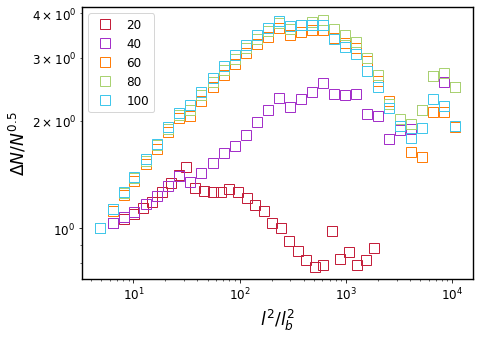

In [7]:
data = pd.read_csv(r'I:\Google Drive\Research projects\DF\Figures\fig2-GNF\GNF_data.csv')
plt.figure(figsize=(7, 5))
lb = 3 # um
mpp = 0.33 
count = 0
slopeL = []
for name in data.Name.drop_duplicates():
    subdata = data.loc[data.Name==name]    
    # to plot, xx yy
    xx = subdata.n / (lb/mpp)**2
    yy = subdata.d / subdata.n**.5 
    yy = yy / yy.iat[0]
    plt.plot(xx[0:len(xx):3], yy[0:len(yy):3], label=str(name), ls='', marker='s',
            mfc=(0,0,0,0), mec=wowcolor(count), markersize=10)
    # to fit
    x = xx.loc[xx<2e1]
    y = yy.loc[xx<2e1] 
    xf, yf, xt, yt, slope = label_slope(x, y, location='n')
#     plt.plot(xf, yf, ls='--', color='black')
#     plt.text(xt, yt, '{:.2f}'.format(slope))
    count += 1
    slopeL.append(slope)
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$l^2/l_b^2$')
plt.ylabel('$\Delta N/N^{0.5}$')

Text(0, 0.5, 'slope')

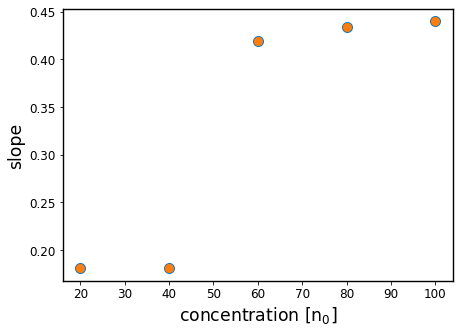

In [8]:
n = [20, 40, 60, 80, 100]
plt.figure(figsize=(7, 5))
plt.plot(n, slopeL, ls='', marker='o', mfc=wowcolor(2),
        markersize=10, lw='2')
plt.xlabel('concentration [n$_0$]')
plt.ylabel('slope')

* Improved data - multiple repeats

## Alternative method for DF

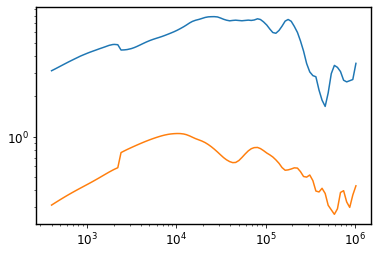

In [17]:
folder = r'D:\Wei\Dynamics_raw\df2_result\60'
data = pd.read_csv(os.path.join(folder, 'df_average.csv'))
plt.plot(data.n, data.d/data.n**0.5)
folder = r'D:\Wei\Dynamics_raw\df2_result\100'
data = pd.read_csv(os.path.join(folder, 'df_average.csv'))
plt.plot(data.n, data.d/data.n**0.5)
plt.xscale('log')
plt.yscale('log')

In [ ]:
folder = r'D:\Wei\Dynamics_raw\df2_result'
name = ['40', '60', '80', '100']
